Create a ad hoc network having 10 nodes and a total number of 32 connections.
At each node, generate the data according to the following model:

$$ y_k(n) = \boldsymbol{\theta}_0^T \mathbf{x}_k(n) + \eta_k(n), 1 \leq k \leq 10, $$

where
* $ \boldsymbol{\theta}_0 \in \mathbb{R}^{60} $ is a constant vector, generated via $ N(0,1) $.
* all input vectors $ \mathbf{x}_k(n) \in \mathbb{R}^{60} $ are i.i.d generated via $ N(0,1) $.
* noise samples $ \eta_k(n) \in \mathbb{R}^1 $ are independently generated from zero mean Gaussians with variances corresponding to different signal-to-noise level, varying from 20-25 dBs in each node.

For the unknown vector estimation employ the following algorithms:
* combine-then-adapt diffusion APSM. Parameters: $ \mu_n = 0.5 \times M_n $, $ \epsilon_k = \sqrt 2 \sigma_k $, $ q = 20 $.
* adapt-then-combine LMS. Parameter: step size = 0.03.
* combine-then-adapt LMS. Parameter: step size = 0.03.
* noncooperative LMS.

Choose $ a_{mk} $ according to Metropolis rule:

$$ a_{mk} = \left\{
\begin{aligned}
&\frac{1}{max(n_k,n_m)}, &k \neq m,\ k,\ m\ are\ neighbors, \\
&0, &m \neq k, \\
&1-\sum_{i \neq k} a_{ik}, &m = k.
\end{aligned}
\right.
$$

Run 100 independent experiments and plot the average MSD per iteration in dBs:

$$ MSD(n) = 10 \log_{10} \left( \frac{1}{K} \sum_{k=1}^{K} \Vert \boldsymbol{\theta}_{k}(n) - \boldsymbol{\theta}_0 \Vert^2 \right). $$

* class networkController: generate $ \boldsymbol{\theta}_0 $ and send it to nodes, signal nodes to begin training, record training history, compute MSD.
* class node: generate input vector and noise, run algorithms, communicate with adjacent nodes.

In [1]:
# Import packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

class networkController: generate $ \boldsymbol{\theta}_0 \in \mathbb{R}^{60} $ via $ N(0,1) $, compute true value according to sample, signal nodes to begin training, record training history, compute MSD.

In [2]:
# networkController
class networkController:
    
    def __init__(self):
        self.true_theta = np.zeros(60) # initialise theta0 in R^60
        self.energy = 0 # initialise energy level of signal
        self.nodes = [networkNode(i,self) for i in range(10)] # initialise nodelist
        self.count_nodes = len(self.nodes)
        
        # initialise training history
        self.caASPM_history = np.zeros(0)
        self.acLMS_history = np.zeros(0)
        self.caLMS_history = np.zeros(0)
        self.ncLMS_history = np.zeros(0)
        
        # algorithms
        self.algorithms = Algorithms(self)
    
    # generate theta0 via standard normal distribution
    def genTheta(self):
        self.true_theta = np.random.randn(60)
        self.energy = np.linalg.norm(self.true_theta)**2
        return
    
    # train models for iters iterations using selected algorithm
    def startTrain(self, iters: int, algorithm: str, initial_iters = 0, mu = 0.03):
        # clear theta vectors in all nodes
        self.clearThetas()
        
        # update adjacent vectors and convert node.adjacent_nodes from sets to lists
        for node in self.nodes:
            node.clearSampleHistory()
            node.adjacent_nodes = list(node.adjacent_nodes)
            node.updateArgs()
            node.mu = mu
            node.noise = np.sqrt(self.energy*np.power(10,-node.snr/10))
            
        # combine-then-adapt ASPM
        if algorithm == "caASPM":
            self.algorithms.caASPM(initial_iters, iters)
        
        # adapt-then-combine LMS
        elif algorithm == "acLMS":
            self.algorithms.acLMS(iters)
        
        # combine-then-adapt LMS
        elif algorithm == "caLMS":
            self.algorithms.caLMS(iters)
        
        # noncooperative LMS
        elif algorithm == "ncLMS":
            self.algorithms.ncLMS(iters)
        
        # convert node.adjacent_nodes from lists to sets
        for node in self.nodes:
            node.adjacent_nodes = set(node.adjacent_nodes)
        
        return
    
    # print general network information
    def networkInf(self):
        count_connections = (sum(node.count_nodes for node in self.nodes)-len(self.nodes))//2
        print("This network has %d nodes with %d connections."%(len(self.nodes),count_connections))
        print("The theta vector of this network is:\n",self.true_theta)
        print("The l^2 norm of the theta vector is:",np.sqrt(self.energy),"\n")
        return
    
    # plot training history
    def plotHistory(self):
        x = np.linspace(1,len(self.caASPM_history),len(self.caASPM_history))
        
        plt.figure()
        plt.plot(x,self.caASPM_history,color='grey',linewidth=1.0,linestyle='-',label = "caASPM")
        plt.plot(x,self.acLMS_history,color='darkred',linewidth=1.0,linestyle='-',label = "acLMS")
        plt.plot(x,self.caLMS_history,color='lightgrey',linewidth=1.0,linestyle='-',label = "caLMS")
        plt.plot(x,self.ncLMS_history,color='black',linewidth=1.0,linestyle='--',label = "ncLMS")
        plt.legend()
        plt.show()
        
        return
    
    def clearThetas(self):
        for node in self.nodes:
            node.theta = np.zeros(60)
        return
    
    # compute msd in dBs
    def computeMSD(self) -> float:
        msd = 0
        for node in self.nodes:
            msd += np.linalg.norm(self.true_theta-node.theta)**2
        msd = 10*np.log(msd/self.count_nodes)/np.log(10)
        return msd
    
    def computeY(self, x: np.array, noise: float) -> float:
        return np.dot(self.true_theta,x)+np.random.normal(0,noise)
    
    # clear training history
    def clearHistory(self):
        self.caASPM_history = np.zeros(0)
        self.acLMS_history = np.zeros(0)
        self.caLMS_history = np.zeros(0)
        self.ncLMS_history = np.zeros(0)
        return

class networkNode: add and delete adjacent nodes, generate sample, train the regressor $ \theta $, compute energy of the noise.

In [3]:
# networkNode
class networkNode:
    
    def __init__(self, num: int, controller: networkController):
        self.controller = controller
        self.num = num
        
        # main arguments
        self.theta = np.zeros(60) # initialise theta in R^60
        self.mu = 0.03 # initialise mu_k
        self.omega = np.zeros(0) # initialise convex combination arguments
        self.x = np.zeros((1,60)) # initialise sample history
        self.y = np.zeros(1) # initialise output history
        self.error = np.zeros(0) # initialise error vector
        self.psi = np.zeros(60) # initialise psi vector
        self.snr = np.random.uniform(20,25) # initialise signal-to-noise ratio
        self.noise = 0 # initialise noise
        
        # adjacent nodes
        self.adjacent_nodes = set([self]) # initialise adjacent nodelist
        self.count_nodes = 1 # count adjacent nodes
        self.adjacent_vector = np.zeros(0) # initialise matrix C and A = C
    
    # connect self and nodes in node_list
    # elements in node_list are numbers of node
    def addAdjacentNode(self, node_list: list):
        for node_num in node_list:
            node = self.controller.nodes[node_num]
            self.adjacent_nodes.add(node)
            node.adjacent_nodes.add(self)
            node.count_nodes = len(node.adjacent_nodes)
        self.count_nodes = len(self.adjacent_nodes)
        return
    
    # disconnect self and nodes in node_list
    # elements in node_list are numbers of node
    def removeAdjacentNode(self, node_list: list):
        for node_num in node_list:
            node = self.controller.nodes[node_num]
            self.adjacent_nodes.discard(node)
            node.adjacent_nodes.discard(self)
            node.count_nodes = len(node.adjacent_nodes)
        self.adjacent_nodes.add(self)
        self.count_nodes = len(self.adjacent_nodes)
        return
    
    def sample(self):
        sample = np.random.normal(0,1,(1,60))
        y = self.controller.computeY(sample[0],self.noise)
        self.x = np.append(self.x,sample,0)
        self.y = np.append(self.y,y)
        return
    
    def popEarliestSample(self):
        self.x = self.x[1:]
        self.y = self.y[1:]
        return
    
    def sampleAndPop(self):
        self.popEarliestSample()
        self.sample()
        return
    
    def updateArgs(self):
        # initialise a count_nodes-dimensionial error vector
        self.error = np.zeros(self.count_nodes)
        
        # select C and A = C
        self.adjacent_vector = np.zeros(self.count_nodes)
        for i in range(self.count_nodes):
            if self.adjacent_nodes[i].num != self.num:
                self.adjacent_vector[i] = 1/np.max([self.count_nodes,self.adjacent_nodes[i].count_nodes])
            else:
                mark = i
        self.adjacent_vector[mark] = 1-np.sum(self.adjacent_vector)
                
        return
    
    def clearSampleHistory(self):
        self.x = np.zeros((1,60))
        self.y = np.zeros(1)

class algorithms: realise all training algorithms and store temporary variables.

In [4]:
class Algorithms:
    
    def __init__(self, controller: networkController):
        # network controller
        self.controller = controller
        
        # temporary arguments
        self.beta = 0
        self.M = 0
    
    # Algorithms
    # combine-then-adapt ASPM
    def caASPM(self, initial_iters: int, iters: int):
        for node in self.controller.nodes:
            node.popEarliestSample()
        
        for i in range(initial_iters+iters):
            #sample
            if i < initial_iters:
                for node in self.controller.nodes:
                    node.sample()
            else:
                for node in self.controller.nodes:
                    node.sampleAndPop()
            
            # compute psi
            for node in self.controller.nodes:
                node.psi = np.zeros(60)
                for j in range(node.count_nodes):
                    node.psi += node.adjacent_vector[j]*node.adjacent_nodes[j].theta
            
            # compute theta
            for node in self.controller.nodes:
                self.updatecaASPM(node,np.minimum(i+1,initial_iters))
            
            # compute msd and add into training history
            self.recordHistory("caASPM")
            
        return
        
    # adapt-then-combine LMS
    def acLMS(self, iters: int):
        for _ in range(iters):
            # sample
            for node in self.controller.nodes:
                node.sampleAndPop()
            
            # compute error
            for node in self.controller.nodes:
                for i in range(node.count_nodes):
                    node.error[i] = node.adjacent_nodes[i].y[-1]-np.dot(node.theta,node.adjacent_nodes[i].x[-1])
            
            # compute psi
            for node in self.controller.nodes:
                node.psi = np.zeros(60)
                for i in range(node.count_nodes):
                    node.psi += node.adjacent_vector[i]*node.error[i]*node.adjacent_nodes[i].x[-1]
                node.psi *= node.mu
                node.psi += node.theta
            
            # compute new theta
            for node in self.controller.nodes:
                node.theta = np.zeros(60)
                for i in range(node.count_nodes):
                    node.theta += node.adjacent_vector[i]*node.adjacent_nodes[i].psi
            
            # compute msd and add into training history
            self.recordHistory("acLMS")
            
        return
        
    # combine-then-adapt LMS
    def caLMS(self, iters: int):
        for _ in range(iters):
            # sample
            for node in self.controller.nodes:
                node.sampleAndPop()
                
            # compute psi
            for node in self.controller.nodes:
                node.psi = np.zeros(60)
                for i in range(node.count_nodes):
                    node.psi += node.adjacent_vector[i]*node.adjacent_nodes[i].theta
                
            # compute error
            for node in self.controller.nodes:
                for i in range(node.count_nodes):
                    node.error[i] = node.adjacent_nodes[i].y[-1]-np.dot(node.psi,node.adjacent_nodes[i].x[-1])
                
            # compute new theta
            for node in self.controller.nodes:
                node.theta = np.zeros(60)
                for i in range(node.count_nodes):
                    node.theta += node.adjacent_vector[i]*node.error[i]*node.adjacent_nodes[i].x[-1]
                node.theta *= node.mu
                node.theta += node.psi
                
            # compute msd and add into training history
            self.recordHistory("caLMS")
        
        return
        
    # noncooperative LMS
    def ncLMS(self, iters: int):
        for _ in range(iters):
            # sample
            for node in self.controller.nodes:
                node.sampleAndPop()
                
            # compute error
            for node in self.controller.nodes:
                node.error[0] = node.y[-1]-np.dot(node.theta,node.x[-1])
                
            # compute new theta
            for node in self.controller.nodes:
                node.theta += node.mu*node.error[0]*node.x[-1]
            
            # compute msd and add into training history
            self.recordHistory("ncLMS")
            
        return
    
    # compute msd and add into training history
    def recordHistory(self, algorithm: str):
        current_msd = self.controller.computeMSD()
        
        # combine-then-adapt ASPM
        if algorithm == "caASPM":
            self.controller.caASPM_history = np.append(self.controller.caASPM_history,current_msd)
        
        # adapt-then-combine LMS
        elif algorithm == "acLMS":
            self.controller.acLMS_history = np.append(self.controller.acLMS_history,current_msd)
        
        # combine-then-adapt LMS
        elif algorithm == "caLMS":
            self.controller.caLMS_history = np.append(self.controller.caLMS_history,current_msd)
        
        # noncooperative LMS
        elif algorithm == "ncLMS":
            self.controller.ncLMS_history = np.append(self.controller.ncLMS_history,current_msd)
        
        return
    
    # compute beta and M in caASPM
    def updatecaASPM(self, node: networkNode, window_len: int):
        node.theta = np.zeros(60)
        self.beta = 0
        self.M = 0
        
        for i in range(window_len):
            self.beta = node.y[i]-np.dot(node.x[i],node.psi)
            self.beta = np.maximum(0,abs(self.beta)-np.sqrt(2)*node.noise)*np.sign(self.beta)
            self.beta /= np.linalg.norm(node.x[i])**2
            node.theta += self.beta*node.x[i]
            self.M += (self.beta*np.linalg.norm(node.x[i]))**2
        
        node.theta /= window_len
        self.M /= window_len
        if np.linalg.norm(node.theta) != 0:
            self.M /= np.linalg.norm(node.theta)**2
        node.mu = self.M/2
        node.theta *= node.mu
        node.theta += node.psi

In [5]:
controller = networkController()

In [6]:
controller.nodes[0].addAdjacentNode([1,4,6,8])
controller.nodes[1].addAdjacentNode([2,5,8])
controller.nodes[2].addAdjacentNode([3,7,9])
controller.nodes[3].addAdjacentNode([6,7,9])
controller.nodes[4].addAdjacentNode([2,5,7])
controller.nodes[5].addAdjacentNode([0,2,8,9])
controller.nodes[6].addAdjacentNode([1,2,7])
controller.nodes[7].addAdjacentNode([5,8,9])
controller.nodes[8].addAdjacentNode([2,3,4])
controller.nodes[9].addAdjacentNode([4,6,8])

In [7]:
controller.genTheta()
controller.networkInf()

This network has 10 nodes with 32 connections.
The theta vector of this network is:
 [ 2.4250581  -0.81994317  0.68621845 -1.98669764 -1.18526036 -0.15485061
  0.88092034  1.88695995  1.0779583  -0.21226925  0.77155735 -2.67727363
 -0.43006644  0.06015769 -1.18660382 -0.34373355  0.28849638  0.46488312
 -0.04708569  0.5234727  -0.75844039 -1.12556115  0.57711949 -0.41910994
  0.40246567 -0.31348746 -1.7982772   1.83262     1.43856167 -0.57735627
  0.76651832 -1.01415337 -0.45058015  0.89370386  0.36647036 -0.24948353
 -0.87516568 -1.49256146 -0.1512969   0.8052612  -1.26119383 -0.33445449
  0.32694112 -1.57786193 -1.17856221 -0.0941641   0.29317245 -0.92308724
 -0.45750063 -0.69892543 -1.17651579 -1.57914082  0.35227647 -0.41548139
  0.91586874  0.88072384 -0.22548747 -0.48283521 -1.24369205  0.27269137]
The l^2 norm of the theta vector is: 7.81725394418851 



In [8]:
controller.startTrain(980,"caASPM",initial_iters = 20)
controller.startTrain(1000,"acLMS")
controller.startTrain(1000,"caLMS")
controller.startTrain(1000,"ncLMS")

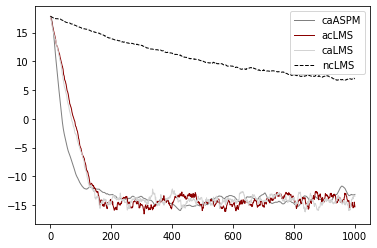

In [9]:
controller.plotHistory()
controller.clearHistory()